https://www.tensorflow.org/tutorials/generative/cvae

In [1]:
import PIL
import glob
import time
from IPython import display

import imageio
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(train_size)
    .batch(batch_size)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(test_size)
    .batch(batch_size)
)

In [6]:
class CVAE(tf.keras.Model):
    '''Convolutional variational autoencoder.'''

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            
            tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=3,
                strides=(2, 2),
                activation='relu'
            ),

            tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=(2, 2),
                activation='relu'
            ),

            tf.keras.layers.Flatten(),

            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),

            tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),

            tf.keras.layers.Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),

            tf.keras.layers.Conv2DTranspose(
                filters=32,
                kernel_size=3,
                strides=2,
                padding='same',
                activation='relu'
            ),

            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1,
                kernel_size=3,
                strides=1,
                padding='same'
            ),
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))

        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)

        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
            
        return logits

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)

    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    '''
    Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    '''

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
epochs = 10

# Set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# Keeping the random vector constant for generation (predictions) so it will be easier to see the improvement
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

In [9]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig(f'data/image_at_epoch_{epoch:04d}.png')
    plt.show()

In [10]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate

for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, test set ELBO: -156.61764526367188, time elapse for current epoch: 7.656338691711426


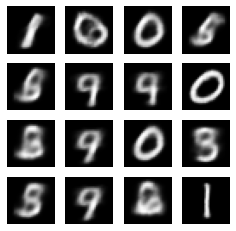

In [11]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()

    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    end_time = time.time()

    loss = tf.keras.metrics.Mean()

    for test_x in test_dataset:
        loss(compute_loss(model, test_x))

    elbo = -loss.result()

    display.clear_output(wait=False)

    print(f'Epoch: {epoch}, test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')

    generate_and_save_images(model, epoch, test_sample)

In [14]:
def display_image(epoch_no):
    return PIL.Image.open(f'data/image_at_epoch_{epoch_no:04d}.png')

(-0.5, 287.5, 287.5, -0.5)

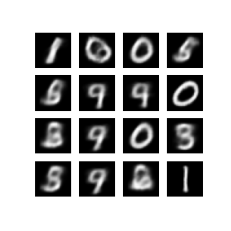

In [15]:
plt.imshow(display_image(epoch))
plt.axis('off')

In [16]:
anim_file = 'data/cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('data/image*.png')
    filenames = sorted(filenames)

    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\luisc\AppData\Local\Temp\ipykernel_17600\166740674.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\luisc\AppData\Local\Temp\ipykernel_17600\166740674.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



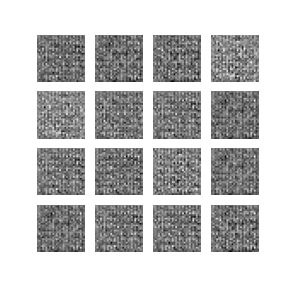

In [17]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

In [20]:
def plot_latent_images(model, n, digit_size=28):
    '''Plots n x n digit images decoded from the latent space.'''

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))

    image_width = digit_size * n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoced = model.sample(z)
            digit = tf.reshape(x_decoced[0], (digit_size, digit_size))

            image[
                i * digit_size:(i + 1) * digit_size,
                j * digit_size:(j + 1) * digit_size
            ] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.show()

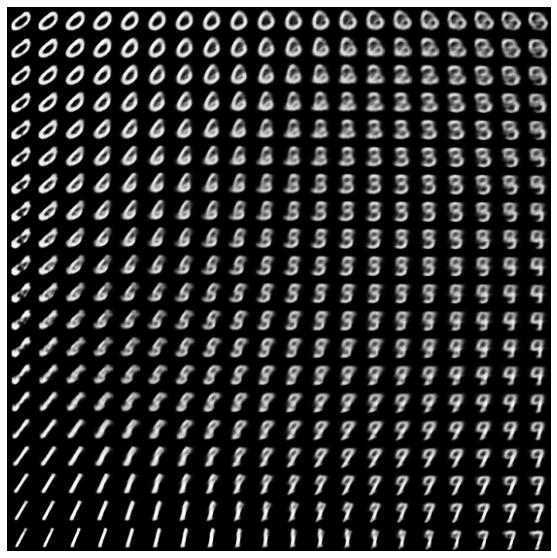

In [21]:
plot_latent_images(model, 20)